Data loaded successfully. Shape: (76, 12)

Basic Statistics:
       water_flow  water_head  turbine_type_encoded  turbine_age  \
count   76.000000   76.000000             76.000000    76.000000   
mean   103.289342   54.953158              0.986842     6.156053   
std     14.272668    7.435677              0.824515     3.352282   
min     76.430000   43.270000              0.000000     1.290000   
25%     91.410000   48.885000              0.000000     3.217500   
50%    101.815000   53.745000              1.000000     6.085000   
75%    116.085000   60.925000              2.000000     8.697500   
max    126.380000   69.450000              2.000000    15.820000   

       water_temperature  season_encoded  maintenance_days  reservoir_level  \
count          76.000000       76.000000         76.000000        76.000000   
mean           14.695921        1.460526          4.105263        79.821842   
std             2.999832        1.136554          2.543378         8.796103   
min       

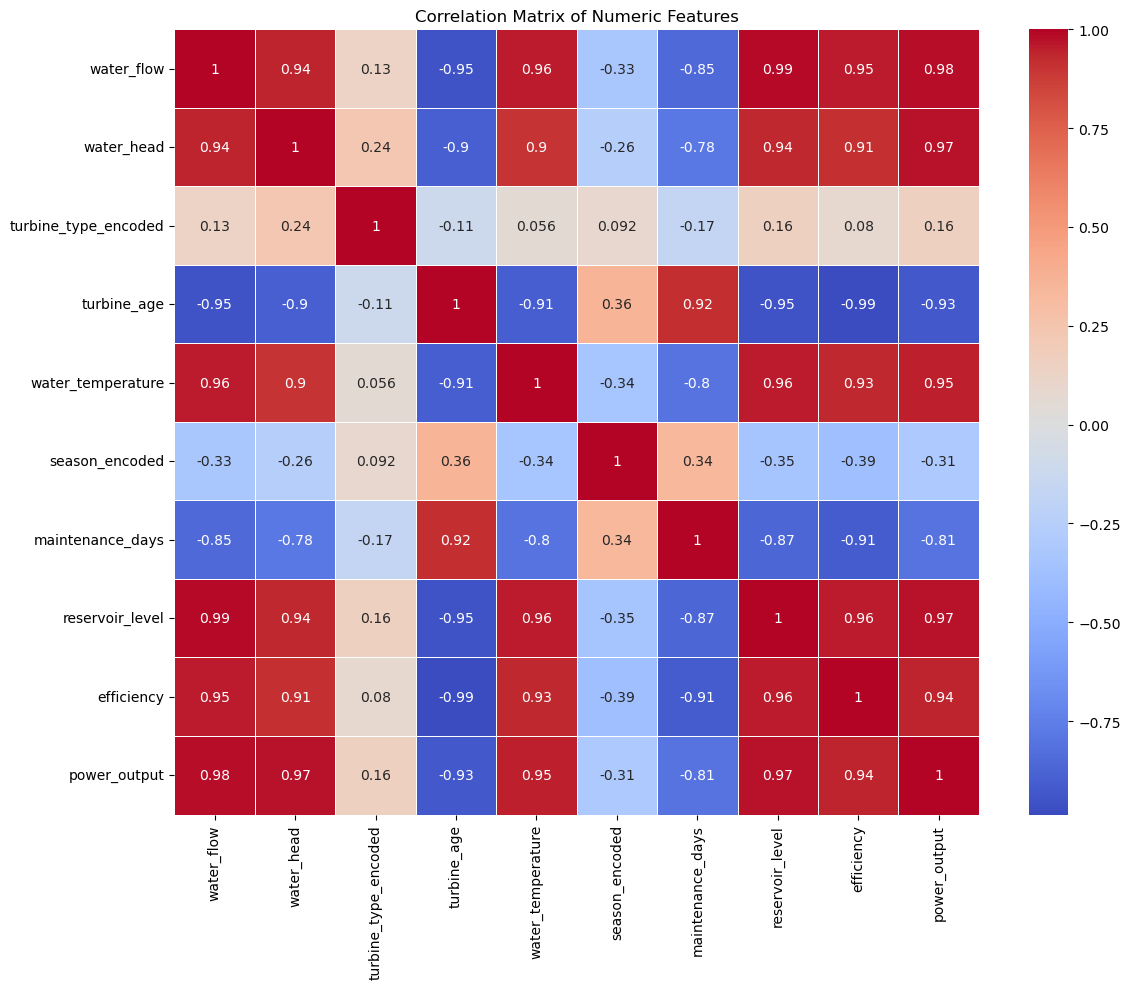

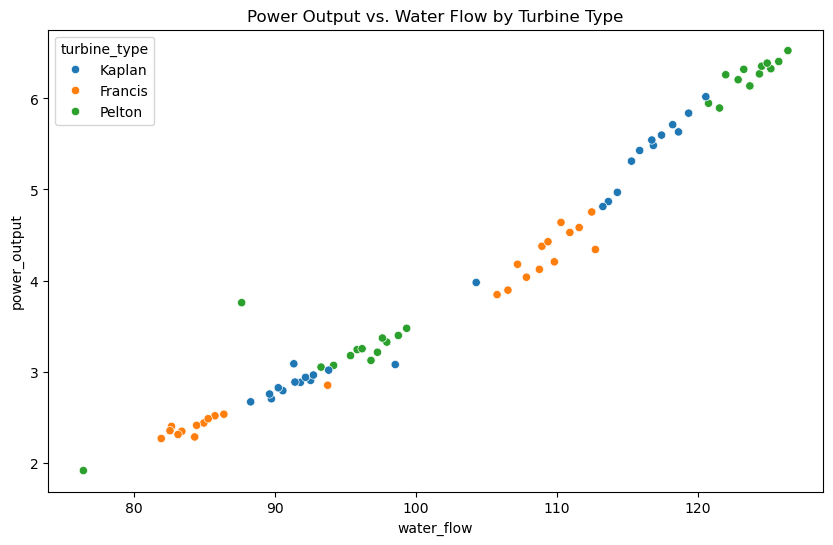

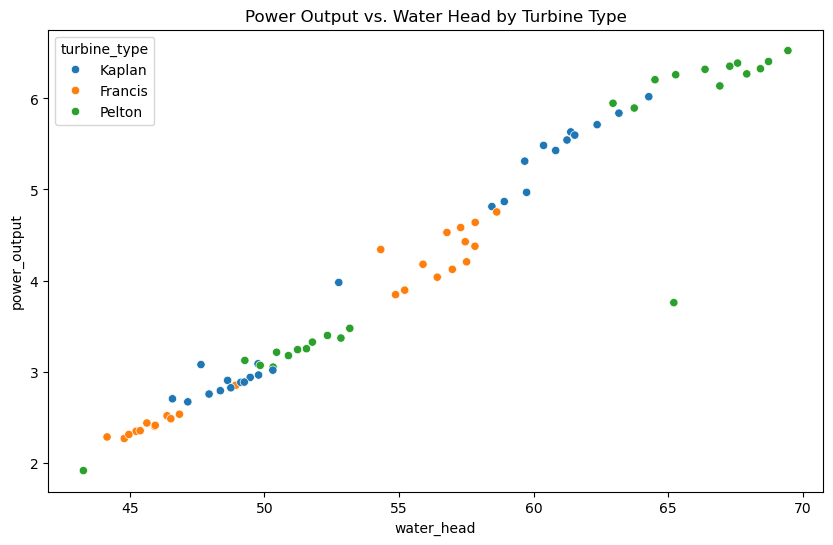

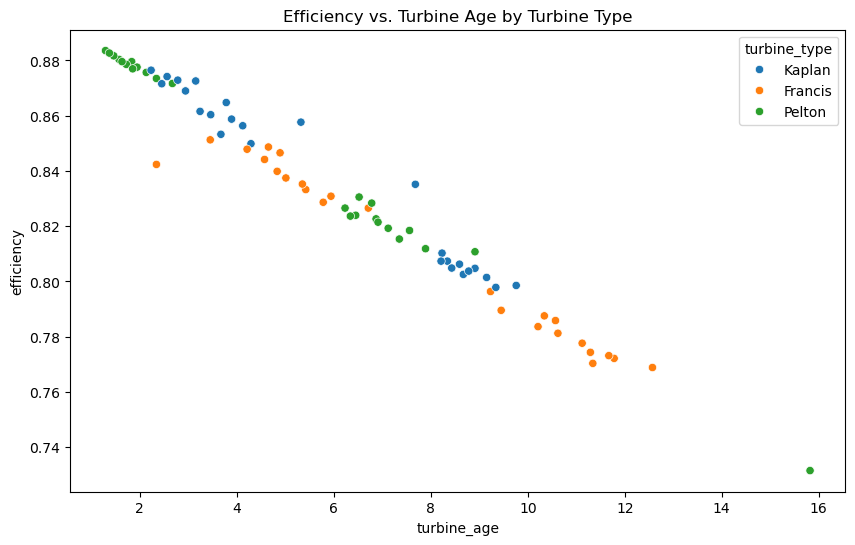

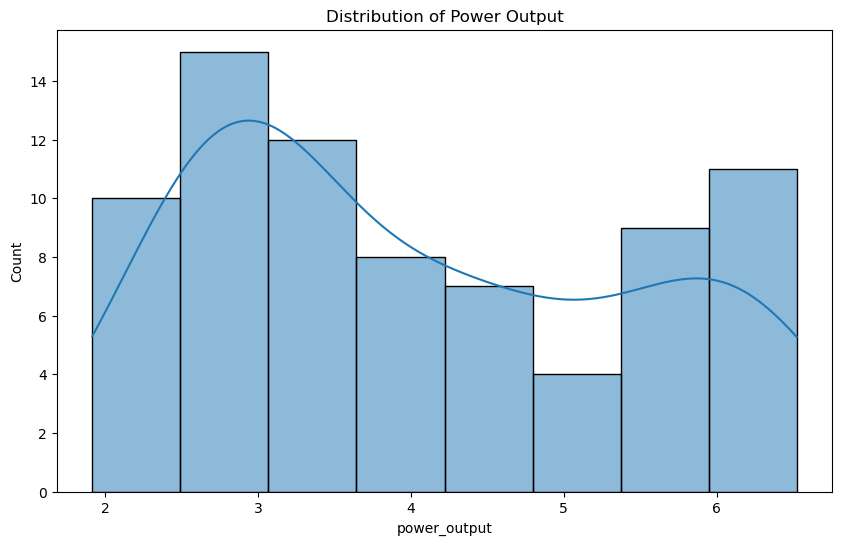

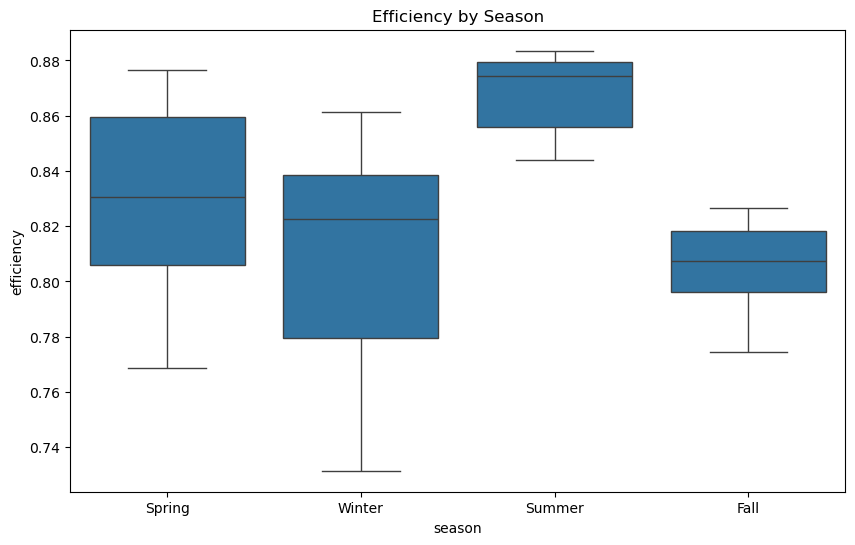

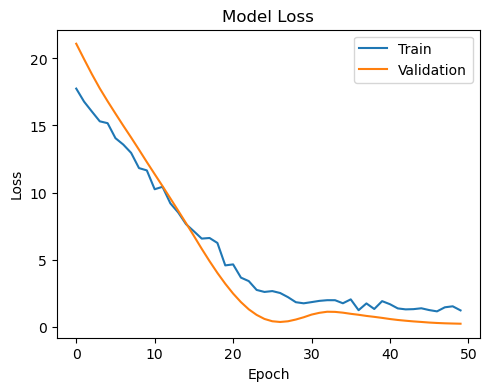

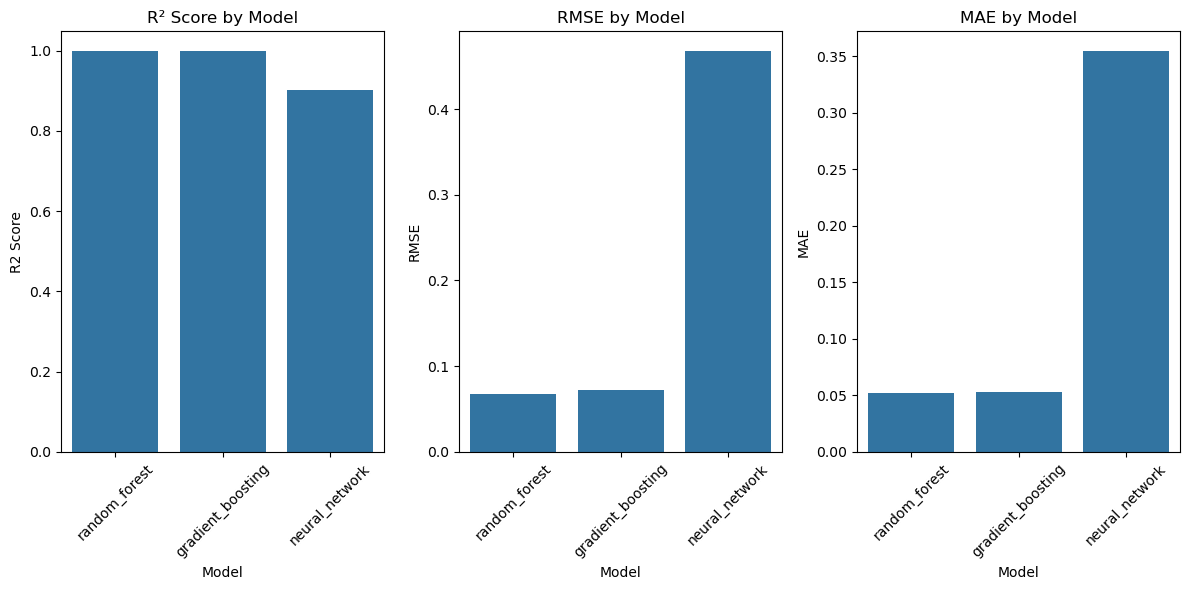

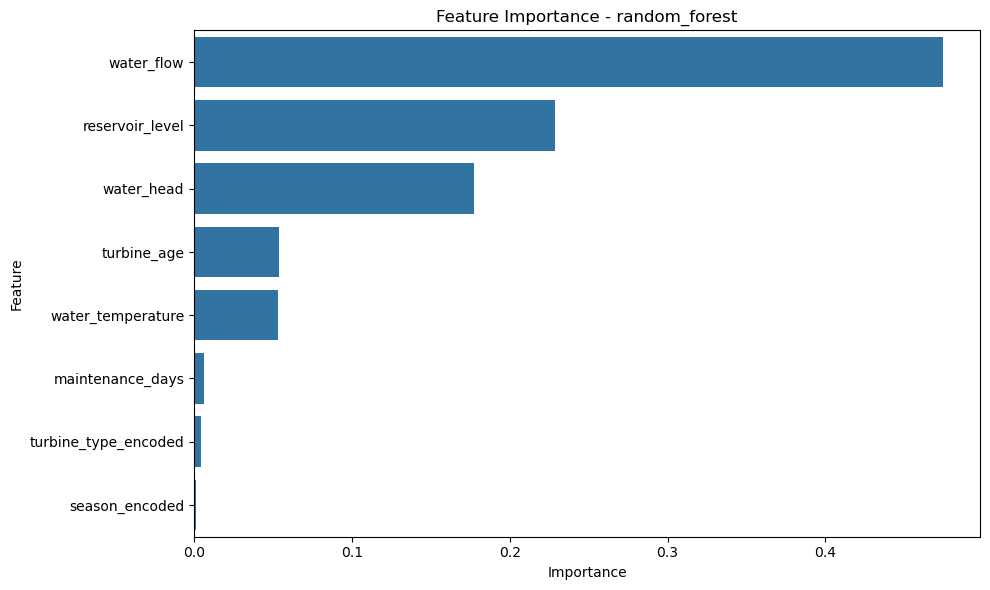

In [1]:
"""
Hydropower Efficiency Optimization with Machine Learning
========================================================

This project demonstrates how to use machine learning to optimize hydropower efficiency by:
1. Processing and analyzing historical hydropower plant data
2. Building prediction models for power output based on various parameters
3. Optimizing operation parameters to maximize efficiency
4. Visualizing results and performance metrics
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import optuna
import joblib
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class HydropowerDataProcessor:
    """Class for processing hydropower plant data."""
    
    def __init__(self, data_path=None):
        """Initialize data processor with optional path to data."""
        self.data_path = data_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        
    def load_data(self, data_path=None):
        """Load data from CSV file."""
        if data_path:
            self.data_path = data_path
        
        if self.data_path is None:
            # Generate synthetic data if no file is provided
            print("No data path provided. Generating synthetic data...")
            self.generate_synthetic_data()
            return self.data
        
        try:
            self.data = pd.read_csv(self.data_path)
            print(f"Data loaded successfully. Shape: {self.data.shape}")
            return self.data
        except Exception as e:
            print(f"Error loading data: {e}")
            print("Generating synthetic data instead...")
            self.generate_synthetic_data()
            return self.data
    
    def generate_synthetic_data(self, n_samples=10000):
        """Generate synthetic hydropower plant data for demonstration."""
        # Set random seed for reproducibility
        np.random.seed(42)
        
        # Generate features
        water_flow = np.random.normal(100, 20, n_samples)  # m³/s
        water_head = np.random.normal(50, 10, n_samples)   # meters
        turbine_type = np.random.choice(['Kaplan', 'Francis', 'Pelton'], n_samples)
        turbine_age = np.random.uniform(0, 20, n_samples)  # years
        water_temperature = np.random.normal(15, 5, n_samples)  # Celsius
        season = np.random.choice(['Spring', 'Summer', 'Fall', 'Winter'], n_samples)
        maintenance_days = np.random.poisson(5, n_samples)  # days since last maintenance
        reservoir_level = np.random.normal(80, 10, n_samples)  # percentage
        
        # Convert categorical variables to numeric
        turbine_type_encoded = np.zeros(n_samples)
        turbine_type_encoded[turbine_type == 'Francis'] = 1
        turbine_type_encoded[turbine_type == 'Pelton'] = 2
        
        season_encoded = np.zeros(n_samples)
        season_encoded[season == 'Summer'] = 1
        season_encoded[season == 'Fall'] = 2
        season_encoded[season == 'Winter'] = 3
        
        # Calculate theoretical power output
        # P = η * ρ * g * Q * H
        # Where:
        # η = efficiency (varies by turbine type and conditions)
        # ρ = water density (1000 kg/m³)
        # g = gravitational acceleration (9.81 m/s²)
        # Q = water flow (m³/s)
        # H = water head (m)
        
        # Base efficiency varies by turbine type
        base_efficiency = np.zeros(n_samples)
        base_efficiency[turbine_type == 'Kaplan'] = 0.90
        base_efficiency[turbine_type == 'Francis'] = 0.85
        base_efficiency[turbine_type == 'Pelton'] = 0.88
        
        # Efficiency decreases with turbine age
        age_factor = 1 - (0.005 * turbine_age)
        
        # Efficiency varies with water flow (relative to optimal design flow)
        optimal_flow = 100  # Assuming this is the design flow rate
        flow_factor = 1 - 0.1 * np.abs((water_flow - optimal_flow) / optimal_flow)
        flow_factor = np.clip(flow_factor, 0.7, 1.0)  # Limit the penalty
        
        # Maintenance affects efficiency
        maintenance_factor = 1 - 0.01 * np.clip(maintenance_days / 30, 0, 0.2)
        
        # Final efficiency
        efficiency = base_efficiency * age_factor * flow_factor * maintenance_factor
        
        # Calculate power output (MW)
        # Constant: 1000 (water density) * 9.81 (gravity) / 1,000,000 (convert to MW)
        power_constant = 1000 * 9.81 / 1000000
        power_output = efficiency * power_constant * water_flow * water_head
        
        # Add some noise to make it more realistic
        power_output = power_output * np.random.normal(1, 0.05, n_samples)
        
        # Create DataFrame
        data = pd.DataFrame({
            'water_flow': water_flow,
            'water_head': water_head,
            'turbine_type': turbine_type,
            'turbine_type_encoded': turbine_type_encoded,
            'turbine_age': turbine_age,
            'water_temperature': water_temperature,
            'season': season,
            'season_encoded': season_encoded,
            'maintenance_days': maintenance_days,
            'reservoir_level': reservoir_level,
            'efficiency': efficiency,
            'power_output': power_output
        })
        
        self.data = data
        print(f"Synthetic data generated. Shape: {data.shape}")
        return data
    
    def exploratory_analysis(self):
        """Perform exploratory data analysis and generate visualizations."""
        if self.data is None:
            print("No data available. Please load data first.")
            return
        
        # Create output directory for plots
        os.makedirs('plots', exist_ok=True)
        
        # Display basic statistics
        print("\nBasic Statistics:")
        print(self.data.describe())
        
        # Check for missing values
        print("\nMissing Values:")
        print(self.data.isnull().sum())
        
        # Correlation matrix
        plt.figure(figsize=(12, 10))
        numeric_data = self.data.select_dtypes(include=[np.number])
        correlation = numeric_data.corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Matrix of Numeric Features')
        plt.tight_layout()
        plt.savefig('plots/correlation_matrix.png')
        
        # Power output vs. Water Flow
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='water_flow', y='power_output', hue='turbine_type', data=self.data)
        plt.title('Power Output vs. Water Flow by Turbine Type')
        plt.savefig('plots/power_vs_flow.png')
        
        # Power output vs. Water Head
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='water_head', y='power_output', hue='turbine_type', data=self.data)
        plt.title('Power Output vs. Water Head by Turbine Type')
        plt.savefig('plots/power_vs_head.png')
        
        # Efficiency vs. Turbine Age
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='turbine_age', y='efficiency', hue='turbine_type', data=self.data)
        plt.title('Efficiency vs. Turbine Age by Turbine Type')
        plt.savefig('plots/efficiency_vs_age.png')
        
        # Distribution of power output
        plt.figure(figsize=(10, 6))
        sns.histplot(self.data['power_output'], kde=True)
        plt.title('Distribution of Power Output')
        plt.savefig('plots/power_distribution.png')
        
        # Efficiency by season
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='season', y='efficiency', data=self.data)
        plt.title('Efficiency by Season')
        plt.savefig('plots/efficiency_by_season.png')
        
        print("\nExploratory analysis complete. Plots saved to 'plots' directory.")
    
    def prepare_data_for_modeling(self, target='power_output', test_size=0.2, random_state=42):
        """Prepare data for modeling, including feature selection and scaling."""
        if self.data is None:
            print("No data available. Please load data first.")
            return
        
        # Select features
        numeric_features = [
            'water_flow', 'water_head', 'turbine_type_encoded', 
            'turbine_age', 'water_temperature', 'season_encoded',
            'maintenance_days', 'reservoir_level'
        ]
        
        # Split data
        X = self.data[numeric_features]
        y = self.data[target]
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        print(f"Data prepared for modeling. Training set: {self.X_train.shape}, Test set: {self.X_test.shape}")
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def save_processed_data(self, output_dir='processed_data'):
        """Save processed data to files."""
        if self.X_train is None:
            print("No processed data available. Please prepare data first.")
            return
        
        os.makedirs(output_dir, exist_ok=True)
        
        # Save the scaled data
        np.save(f'{output_dir}/X_train_scaled.npy', self.X_train_scaled)
        np.save(f'{output_dir}/X_test_scaled.npy', self.X_test_scaled)
        np.save(f'{output_dir}/y_train.npy', self.y_train)
        np.save(f'{output_dir}/y_test.npy', self.y_test)
        
        # Save the scaler
        joblib.dump(self.scaler, f'{output_dir}/scaler.joblib')
        
        # Save feature names
        pd.DataFrame({'feature_names': self.X_train.columns}).to_csv(
            f'{output_dir}/feature_names.csv', index=False
        )
        
        print(f"Processed data saved to '{output_dir}' directory.")


class HydropowerModelTrainer:
    """Class for training and evaluating machine learning models for hydropower efficiency."""
    
    def __init__(self, X_train=None, X_test=None, y_train=None, y_test=None, 
                 X_train_scaled=None, X_test_scaled=None):
        """Initialize with training and test data."""
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_train_scaled = X_train_scaled
        self.X_test_scaled = X_test_scaled
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.best_score = float('-inf')
        
    def load_data(self, data_dir='processed_data'):
        """Load processed data from files."""
        try:
            self.X_train_scaled = np.load(f'{data_dir}/X_train_scaled.npy')
            self.X_test_scaled = np.load(f'{data_dir}/X_test_scaled.npy')
            self.y_train = np.load(f'{data_dir}/y_train.npy')
            self.y_test = np.load(f'{data_dir}/y_test.npy')
            
            # Load feature names
            feature_names = pd.read_csv(f'{data_dir}/feature_names.csv')['feature_names'].tolist()
            
            # Recreate original dataframes
            self.X_train = pd.DataFrame(data=np.zeros((self.X_train_scaled.shape)), columns=feature_names)
            self.X_test = pd.DataFrame(data=np.zeros((self.X_test_scaled.shape)), columns=feature_names)
            
            # Load scaler
            scaler = joblib.load(f'{data_dir}/scaler.joblib')
            
            print(f"Data loaded from '{data_dir}' directory.")
            return True
        except Exception as e:
            print(f"Error loading data: {e}")
            return False
    
    def train_random_forest(self, n_estimators=100, max_depth=None, random_state=42):
        """Train a Random Forest model."""
        if self.X_train is None or self.y_train is None:
            print("No training data available.")
            return None
        
        print("Training Random Forest model...")
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
            n_jobs=-1
        )
        
        model.fit(self.X_train, self.y_train)
        self.models['random_forest'] = model
        
        # Evaluate the model
        y_pred = model.predict(self.X_test)
        score = r2_score(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        mae = mean_absolute_error(self.y_test, y_pred)
        
        print(f"Random Forest - R² Score: {score:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        # Update best model if this one is better
        if score > self.best_score:
            self.best_score = score
            self.best_model = model
            self.best_model_name = 'random_forest'
        
        return model
    
    def train_gradient_boosting(self, n_estimators=100, learning_rate=0.1, random_state=42):
        """Train a Gradient Boosting model."""
        if self.X_train is None or self.y_train is None:
            print("No training data available.")
            return None
        
        print("Training Gradient Boosting model...")
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state
        )
        
        model.fit(self.X_train, self.y_train)
        self.models['gradient_boosting'] = model
        
        # Evaluate the model
        y_pred = model.predict(self.X_test)
        score = r2_score(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        mae = mean_absolute_error(self.y_test, y_pred)
        
        print(f"Gradient Boosting - R² Score: {score:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        # Update best model if this one is better
        if score > self.best_score:
            self.best_score = score
            self.best_model = model
            self.best_model_name = 'gradient_boosting'
        
        return model
    
    def train_neural_network(self, epochs=50, batch_size=32, verbose=1):
        """Train a Neural Network model."""
        if self.X_train_scaled is None or self.y_train is None:
            print("No scaled training data available.")
            return None
        
        print("Training Neural Network model...")
        
        # Build the model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.X_train_scaled.shape[1],)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        # Train the model
        history = model.fit(
            self.X_train_scaled, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=verbose
        )
        
        self.models['neural_network'] = model
        
        # Evaluate the model
        y_pred = model.predict(self.X_test_scaled).flatten()
        score = r2_score(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        mae = mean_absolute_error(self.y_test, y_pred)
        
        print(f"Neural Network - R² Score: {score:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        # Plot learning curves
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        
        # Save the plot
        os.makedirs('plots', exist_ok=True)
        plt.savefig('plots/nn_learning_curve.png')
        
        # Update best model if this one is better
        if score > self.best_score:
            self.best_score = score
            self.best_model = model
            self.best_model_name = 'neural_network'
        
        return model
    
    def tune_hyperparameters(self, model_type='random_forest', n_trials=100):
        """Use Optuna to tune hyperparameters for the specified model type."""
        if self.X_train is None or self.y_train is None:
            print("No training data available.")
            return None
        
        print(f"Tuning hyperparameters for {model_type} model...")
        
        if model_type == 'random_forest':
            def objective(trial):
                n_estimators = trial.suggest_int('n_estimators', 50, 300)
                max_depth = trial.suggest_int('max_depth', 3, 20)
                min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
                min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
                
                model = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42,
                    n_jobs=-1
                )
                
                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_test)
                score = r2_score(self.y_test, y_pred)
                
                return score
            
        elif model_type == 'gradient_boosting':
            def objective(trial):
                n_estimators = trial.suggest_int('n_estimators', 50, 300)
                learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
                max_depth = trial.suggest_int('max_depth', 3, 10)
                subsample = trial.suggest_float('subsample', 0.6, 1.0)
                
                model = GradientBoostingRegressor(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    subsample=subsample,
                    random_state=42
                )
                
                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_test)
                score = r2_score(self.y_test, y_pred)
                
                return score
            
        elif model_type == 'neural_network':
            def objective(trial):
                # Define hyperparameters to optimize
                units1 = trial.suggest_int('units1', 16, 128)
                units2 = trial.suggest_int('units2', 8, 64)
                dropout1 = trial.suggest_float('dropout1', 0.1, 0.5)
                dropout2 = trial.suggest_float('dropout2', 0.1, 0.5)
                learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
                batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
                
                # Build model with the suggested hyperparameters
                model = Sequential([
                    Dense(units1, activation='relu', input_shape=(self.X_train_scaled.shape[1],)),
                    Dropout(dropout1),
                    Dense(units2, activation='relu'),
                    Dropout(dropout2),
                    Dense(1)
                ])
                
                model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
                
                # Use early stopping to prevent overfitting
                from tensorflow.keras.callbacks import EarlyStopping
                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                
                # Train the model
                model.fit(
                    self.X_train_scaled, self.y_train,
                    epochs=100,  # Set a high number, early stopping will handle it
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=0
                )
                
                # Evaluate
                y_pred = model.predict(self.X_test_scaled).flatten()
                score = r2_score(self.y_test, y_pred)
                
                return score
        else:
            print(f"Unknown model type: {model_type}")
            return None
        
        # Run optimization
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        
        # Print results
        print("Best trial:")
        trial = study.best_trial
        print(f"  Value: {trial.value:.4f}")
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")
        
        # Train the best model
        if model_type == 'random_forest':
            best_model = RandomForestRegressor(
                n_estimators=trial.params['n_estimators'],
                max_depth=trial.params['max_depth'],
                min_samples_split=trial.params['min_samples_split'],
                min_samples_leaf=trial.params['min_samples_leaf'],
                random_state=42,
                n_jobs=-1
            )
            
        elif model_type == 'gradient_boosting':
            best_model = GradientBoostingRegressor(
                n_estimators=trial.params['n_estimators'],
                learning_rate=trial.params['learning_rate'],
                max_depth=trial.params['max_depth'],
                subsample=trial.params['subsample'],
                random_state=42
            )
            
        elif model_type == 'neural_network':
            best_model = Sequential([
                Dense(trial.params['units1'], activation='relu', input_shape=(self.X_train_scaled.shape[1],)),
                Dropout(trial.params['dropout1']),
                Dense(trial.params['units2'], activation='relu'),
                Dropout(trial.params['dropout2']),
                Dense(1)
            ])
            
            best_model.compile(optimizer=Adam(learning_rate=trial.params['learning_rate']), loss='mse')
            
            from tensorflow.keras.callbacks import EarlyStopping
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            
            best_model.fit(
                self.X_train_scaled, self.y_train,
                epochs=100,
                batch_size=trial.params['batch_size'],
                validation_split=0.1,
                callbacks=[early_stop],
                verbose=1
            )
        
        # If not neural network, fit the model
        if model_type != 'neural_network':
            best_model.fit(self.X_train, self.y_train)
        
        # Update models dictionary
        self.models[f'tuned_{model_type}'] = best_model
        
        # Evaluate
        if model_type == 'neural_network':
            y_pred = best_model.predict(self.X_test_scaled).flatten()
        else:
            y_pred = best_model.predict(self.X_test)
            
        score = r2_score(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        mae = mean_absolute_error(self.y_test, y_pred)
        
        print(f"Tuned {model_type} - R² Score: {score:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        # Update best model if this one is better
        if score > self.best_score:
            self.best_score = score
            self.best_model = best_model
            self.best_model_name = f'tuned_{model_type}'
        
        return best_model
    
    def evaluate_models(self):
        """Evaluate all trained models and visualize results."""
        if not self.models:
            print("No models available for evaluation.")
            return
        
        print("\nModel Evaluation Summary:")
        results = []
        
        for name, model in self.models.items():
            if 'neural_network' in name:
                y_pred = model.predict(self.X_test_scaled).flatten()
            else:
                y_pred = model.predict(self.X_test)
                
            score = r2_score(self.y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
            mae = mean_absolute_error(self.y_test, y_pred)
            
            results.append({
                'Model': name,
                'R2 Score': score,
                'RMSE': rmse,
                'MAE': mae
            })
            
            # Create prediction vs actual plot
            plt.figure(figsize=(10, 6))
            plt.scatter(self.y_test, y_pred, alpha=0.5)
            plt.plot([min(self.y_test), max(self.y_test)], [min(self.y_test), max(self.y_test)], 'r--')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title(f'{name} - Predicted vs Actual')
            
            # Save the plot
            os.makedirs('plots', exist_ok=True)
            plt.savefig(f'plots/{name}_predicted_vs_actual.png')
            plt.close()
        
        # Create results table
        results_df = pd.DataFrame(results)
        print(results_df.to_string(index=False))
        
        # Plot model comparison
        plt.figure(figsize=(12, 6))
        
        # Plot R2 scores
        plt.subplot(1, 3, 1)
        sns.barplot(x='Model', y='R2 Score', data=results_df)
        plt.title('R² Score by Model')
        plt.xticks(rotation=45)
        
        # Plot RMSE
        plt.subplot(1, 3, 2)
        sns.barplot(x='Model', y='RMSE', data=results_df)
        plt.title('RMSE by Model')
        plt.xticks(rotation=45)
        
        # Plot MAE
        plt.subplot(1, 3, 3)
        sns.barplot(x='Model', y='MAE', data=results_df)
        plt.title('MAE by Model')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig('plots/model_comparison.png')
        
        print(f"\nBest model: {self.best_model_name} with R² score of {self.best_score:.4f}")
        
        # Feature importance for tree-based models
        if self.best_model_name in ['random_forest', 'gradient_boosting', 'tuned_random_forest', 'tuned_gradient_boosting']:
            feature_importance = pd.DataFrame({
                'Feature': self.X_train.columns,
                'Importance': self.best_model.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance)
            plt.title(f'Feature Importance - {self.best_model_name}')
            plt.tight_layout()
            plt.savefig('plots/feature_importance.png')
            
            print("\nFeature Importance:")
            print(feature_importance.to_string(index=False))
        
        return results_df
    
    def save_models(self, output_dir='models'):
        """Save all trained models to files."""
        if not self.models:
            print("No models available to save.")

def main():
    # Initialize data processor
    data_processor = HydropowerDataProcessor("hydropower_plant_data.csv")
    
    # Load/generate data
    data = data_processor.load_data()  # Will generate synthetic data
    
    # Perform exploratory analysis
    data_processor.exploratory_analysis()
    
    # Prepare data for modeling
    data_processor.prepare_data_for_modeling()
    
    # Initialize model trainer with the processed data
    model_trainer = HydropowerModelTrainer(
        X_train=data_processor.X_train,
        X_test=data_processor.X_test,
        y_train=data_processor.y_train,
        y_test=data_processor.y_test,
        X_train_scaled=data_processor.X_train_scaled,
        X_test_scaled=data_processor.X_test_scaled
    )
    
    # Train models
    model_trainer.train_random_forest()
    model_trainer.train_gradient_boosting()
    model_trainer.train_neural_network()
    
    # Evaluate models
    model_trainer.evaluate_models()
    
    # Optional: Tune hyperparameters (uncomment if you want to run this)
    # model_trainer.tune_hyperparameters(model_type='random_forest', n_trials=20)
    
    print("Hydropower ML optimization complete!")

if __name__ == "__main__":
    main()